# Frequency Analysis of Spatial Anomalies
Analyzing dominant frequency signatures in different cable regions to identify source types (vehicles vs. ships)

In [28]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = Path("../data/reconstructions")
SAMPLING_RATE = 800  # Hz from config.yaml
SPATIAL_SAMPLING = 1.02  # meters (dx)
PATCH_SIZE_CHANNELS = 128  # Number of channels per patch (spatial dimension)

# Calculate spatial distance: patch represents 128 channels * 1.02 m/channel
PATCH_DISTANCE_M = PATCH_SIZE_CHANNELS * SPATIAL_SAMPLING
print(f"Distance per patch (spatial): {PATCH_DISTANCE_M:.2f} meters")

# Load a residual file
residual_files = sorted(list(DATA_DIR.glob("*.hdf5")))
if residual_files:
    print(f"\nFound {len(residual_files)} residual files")
    print(f"Loading: {residual_files[0].name}")
else:
    print("No residual files found!")
    residual_files = sorted(list(DATA_DIR.glob("*.h5")))
    if residual_files:
        print(f"Found {len(residual_files)} .h5 files instead")
        print(f"Loading: {residual_files[0].name}")


Distance per patch (spatial): 130.56 meters

Found 37 residual files
Loading: residual_150005.hdf5


In [29]:
# Load the first residual file
residual_file = residual_files[0]
with h5py.File(residual_file, 'r') as f:
    # Check what keys are available
    print(f"Keys in {residual_file.name}:")
    print(list(f.keys()))
    
    # The residual data is likely stored under a different key structure
    # Check the evaluate.py to see how it's saved
    # Load the data
    if 'residuals' in f:
        residuals = np.array(f['residuals'], dtype=np.float32)
    elif 'data' in f:
        # Might be stored directly as 'data'
        residuals = np.array(f['data'], dtype=np.float32)
    else:
        # Try to find any large dataset
        possible_keys = [k for k in f.keys() if isinstance(f[k], h5py.Dataset)]
        print(f"Possible data keys: {possible_keys}")
        residuals = np.array(f[possible_keys[0]], dtype=np.float32)
    
print(f"Residuals shape: {residuals.shape}")
print(f"  Time dimension: {residuals.shape[0]} samples")
print(f"  Spatial dimension: {residuals.shape[1]} channels")

# Calculate spatial distance in km
total_distance_m = residuals.shape[1] * SPATIAL_SAMPLING
total_distance_km = total_distance_m / 1000
print(f"Total cable distance covered: {total_distance_km:.2f} km")

# Define spatial zones
# Zone 1: 0-2 km (early cable - expected cars)
# Zone 2: 14-16 km (middle cable - expected ships)

#checker lige
ZONE1_START_KM = 0
ZONE1_END_KM = 3/4
ZONE2_START_KM = 14/4
ZONE2_END_KM = 17/4

# Convert to channel indices (with factor 4 consideration)
# Note: If there's a factor of 4 in distance calculation, adjust accordingly
# For now, assuming direct conversion: km * 1000 / 1.02
zone1_start_ch = int(ZONE1_START_KM * 1000 / SPATIAL_SAMPLING)
zone1_end_ch = int(ZONE1_END_KM * 1000 / SPATIAL_SAMPLING)
zone2_start_ch = int(ZONE2_START_KM * 1000 / SPATIAL_SAMPLING)
zone2_end_ch = int(ZONE2_END_KM * 1000 / SPATIAL_SAMPLING)

# Clamp to valid range
zone1_start_ch = max(0, zone1_start_ch)
zone1_end_ch = min(residuals.shape[1], zone1_end_ch)
zone2_start_ch = max(0, zone2_start_ch)
zone2_end_ch = min(residuals.shape[1], zone2_end_ch)

print(f"\nZone 1 (0-2 km): channels {zone1_start_ch}-{zone1_end_ch}")
print(f"  Actual distance: {zone1_start_ch * SPATIAL_SAMPLING / 1000:.2f}-{zone1_end_ch * SPATIAL_SAMPLING / 1000:.2f} km")
print(f"Zone 2 (14-16 km): channels {zone2_start_ch}-{zone2_end_ch}")
print(f"  Actual distance: {zone2_start_ch * SPATIAL_SAMPLING / 1000:.2f}-{zone2_end_ch * SPATIAL_SAMPLING / 1000:.2f} km")

Keys in residual_150005.hdf5:
['data', 'header']
Residuals shape: (8000, 15624)
  Time dimension: 8000 samples
  Spatial dimension: 15624 channels
Total cable distance covered: 15.94 km

Zone 1 (0-2 km): channels 0-735
  Actual distance: 0.00-0.75 km
Zone 2 (14-16 km): channels 3431-4166
  Actual distance: 3.50-4.25 km


In [30]:
# Extract data from each zone
zone1_data = residuals[:, zone1_start_ch:zone1_end_ch]
zone2_data = residuals[:, zone2_start_ch:zone2_end_ch]

print(f"Zone 1 data shape: {zone1_data.shape}")
print(f"Zone 2 data shape: {zone2_data.shape}")

# Calculate statistics for each zone
print(f"\nZone 1 (0-2 km) residual statistics:")
print(f"  Mean: {zone1_data.mean():.4f}")
print(f"  Max: {zone1_data.max():.4f}")
print(f"  Std: {zone1_data.std():.4f}")

print(f"\nZone 2 (14-16 km) residual statistics:")
print(f"  Mean: {zone2_data.mean():.4f}")
print(f"  Max: {zone2_data.max():.4f}")
print(f"  Std: {zone2_data.std():.4f}")


Zone 1 data shape: (8000, 735)
Zone 2 data shape: (8000, 735)

Zone 1 (0-2 km) residual statistics:
  Mean: 0.6501
  Max: 104.6484
  Std: 1.9631

Zone 2 (14-16 km) residual statistics:
  Mean: 0.7993
  Max: 15.1806
  Std: 0.7708


In [31]:
def compute_psd(data, fs, method='welch', freq_max=100):
    """
    Compute Power Spectral Density for data.
    
    Args:
        data: 2D array (time, channels)
        fs: sampling rate in Hz
        method: 'welch' or 'fft'
        freq_max: maximum frequency to plot (Hz)
    
    Returns:
        frequencies, power spectral density
    """
    # Flatten spatial dimension, keep time
    data_flat = data.T.reshape(-1)  # Combine all channels
    
    if method == 'welch':
        # Welch's method: more stable, averaged periodogram
        freqs, pxx = signal.welch(
            data_flat, 
            fs=fs,
            nperseg=min(4096, len(data_flat) // 4),  # Window length
            noverlap=None
        )
    else:  # FFT
        # Simple FFT
        freqs = np.fft.rfftfreq(len(data_flat), 1/fs)
        pxx = np.abs(np.fft.rfft(data_flat))**2 / (len(data_flat) * fs)
    
    # Limit to freq_max
    mask = freqs <= freq_max
    return freqs[mask], pxx[mask]

# Compute PSD for both zones
print("Computing PSD for Zone 1...")
freqs_z1, pxx_z1 = compute_psd(zone1_data, SAMPLING_RATE, method='welch')

print("Computing PSD for Zone 2...")
freqs_z2, pxx_z2 = compute_psd(zone2_data, SAMPLING_RATE, method='welch')

# Find dominant frequencies (peak in PSD)
peak_idx_z1 = np.argmax(pxx_z1)
peak_freq_z1 = freqs_z1[peak_idx_z1]

peak_idx_z2 = np.argmax(pxx_z2)
peak_freq_z2 = freqs_z2[peak_idx_z2]

print(f"\nDominant Frequency Analysis:")
print(f"Zone 1 (0-2 km, expected cars): {peak_freq_z1:.2f} Hz")
print(f"Zone 2 (14-16 km, expected ships): {peak_freq_z2:.2f} Hz")


Computing PSD for Zone 1...
Computing PSD for Zone 2...

Dominant Frequency Analysis:
Zone 1 (0-2 km, expected cars): 0.20 Hz
Zone 2 (14-16 km, expected ships): 0.20 Hz


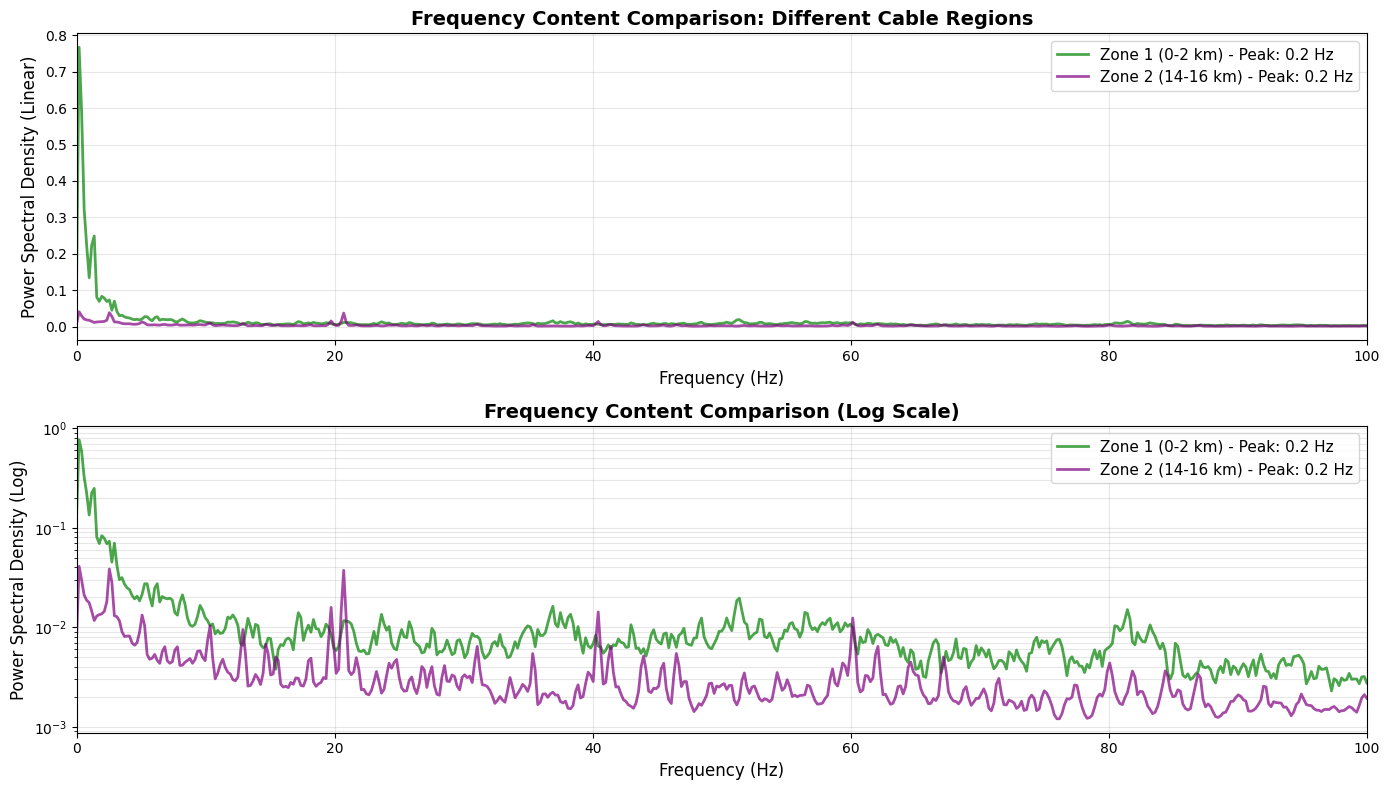

Plot saved to reports/figures/frequency_comparison.png


In [32]:
# Plot overlayed PSD comparison
plt.figure(figsize=(14, 8))

# Linear scale plot
plt.subplot(2, 1, 1)
plt.plot(freqs_z1, pxx_z1, label=f'Zone 1 (0-2 km) - Peak: {peak_freq_z1:.1f} Hz', 
         linewidth=2, color='green', alpha=0.7)
plt.plot(freqs_z2, pxx_z2, label=f'Zone 2 (14-16 km) - Peak: {peak_freq_z2:.1f} Hz', 
         linewidth=2, color='purple', alpha=0.7)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power Spectral Density (Linear)', fontsize=12)
plt.title('Frequency Content Comparison: Different Cable Regions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)

# Log scale plot (better for seeing multiple peaks)
plt.subplot(2, 1, 2)
plt.semilogy(freqs_z1, pxx_z1, label=f'Zone 1 (0-2 km) - Peak: {peak_freq_z1:.1f} Hz', 
             linewidth=2, color='green', alpha=0.7)
plt.semilogy(freqs_z2, pxx_z2, label=f'Zone 2 (14-16 km) - Peak: {peak_freq_z2:.1f} Hz', 
             linewidth=2, color='purple', alpha=0.7)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power Spectral Density (Log)', fontsize=12)
plt.title('Frequency Content Comparison (Log Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, which='both')
plt.xlim(0, 100)

plt.tight_layout()
plt.savefig('../reports/figures/frequency_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to reports/figures/frequency_comparison.png")


In [33]:
# Detailed frequency band analysis
# Break down into frequency bands and compare energy
freq_bands = {
    'Low (0-10 Hz)': (0, 10),
    'Vehicle (10-50 Hz)': (10, 50),
    'Mid (50-100 Hz)': (50, 100)
}

def get_band_energy(freqs, pxx, freq_min, freq_max):
    """Calculate total energy in a frequency band."""
    mask = (freqs >= freq_min) & (freqs <= freq_max)
    return np.trapz(pxx[mask], freqs[mask]) if np.any(mask) else 0

print("\n" + "="*60)
print("FREQUENCY BAND ENERGY ANALYSIS")
print("="*60)

for band_name, (f_min, f_max) in freq_bands.items():
    e1 = get_band_energy(freqs_z1, pxx_z1, f_min, f_max)
    e2 = get_band_energy(freqs_z2, pxx_z2, f_min, f_max)
    
    print(f"\n{band_name}:")
    print(f"  Zone 1 (0-2 km):   {e1:.6f}")
    print(f"  Zone 2 (14-16 km): {e2:.6f}")
    print(f"  Ratio (Z2/Z1):     {e2/e1:.2f}x" if e1 > 0 else f"  Ratio: N/A")



FREQUENCY BAND ENERGY ANALYSIS

Low (0-10 Hz):
  Zone 1 (0-2 km):   0.754208
  Zone 2 (14-16 km): 0.105359
  Ratio (Z2/Z1):     0.14x

Vehicle (10-50 Hz):
  Zone 1 (0-2 km):   0.322475
  Zone 2 (14-16 km): 0.138591
  Ratio (Z2/Z1):     0.43x

Mid (50-100 Hz):
  Zone 1 (0-2 km):   0.314395
  Zone 2 (14-16 km): 0.110230
  Ratio (Z2/Z1):     0.35x



Top 5 peaks in Zone 1 (0-2 km):
  1.4 Hz: 0.248933
  2.0 Hz: 0.083372

Top 5 peaks in Zone 2 (14-16 km):
  2.5 Hz: 0.038520
  20.7 Hz: 0.037390
  19.7 Hz: 0.015854
  40.4 Hz: 0.014263


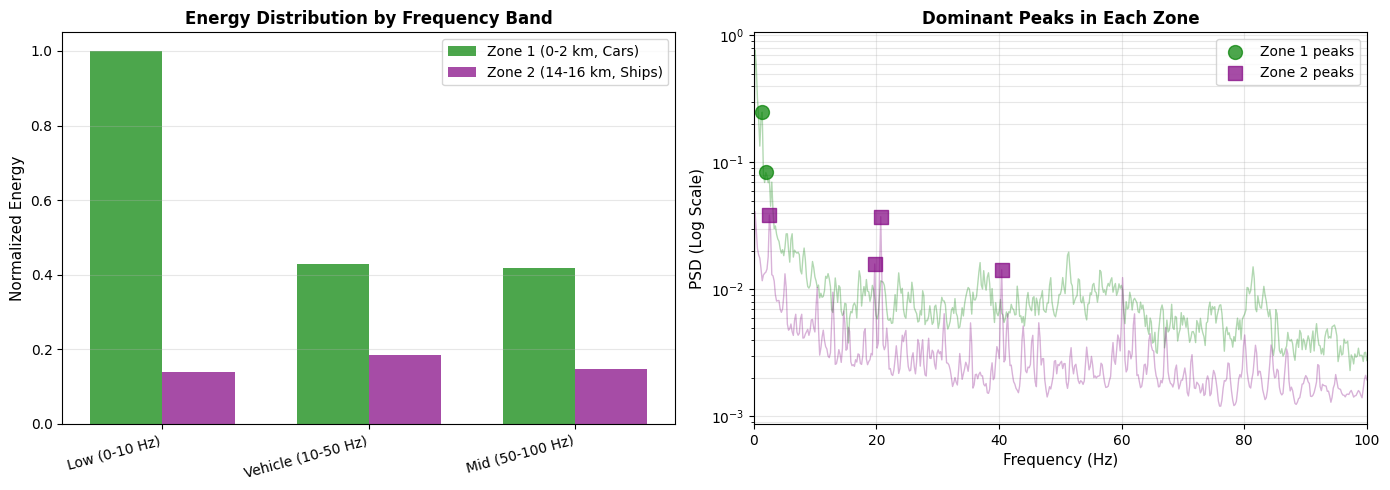


Plot saved to reports/figures/frequency_bands_analysis.png


In [34]:
# Create a frequency band comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

band_names = list(freq_bands.keys())
energies_z1 = []
energies_z2 = []

for band_name, (f_min, f_max) in freq_bands.items():
    e1 = get_band_energy(freqs_z1, pxx_z1, f_min, f_max)
    e2 = get_band_energy(freqs_z2, pxx_z2, f_min, f_max)
    energies_z1.append(e1)
    energies_z2.append(e2)

# Normalize for visualization
max_energy = max(max(energies_z1), max(energies_z2))
energies_z1_norm = [e / max_energy for e in energies_z1]
energies_z2_norm = [e / max_energy for e in energies_z2]

# Bar chart
x = np.arange(len(band_names))
width = 0.35

axes[0].bar(x - width/2, energies_z1_norm, width, label='Zone 1 (0-2 km, Cars)', 
            color='green', alpha=0.7)
axes[0].bar(x + width/2, energies_z2_norm, width, label='Zone 2 (14-16 km, Ships)', 
            color='purple', alpha=0.7)
axes[0].set_ylabel('Normalized Energy', fontsize=11)
axes[0].set_title('Energy Distribution by Frequency Band', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(band_names, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Top frequencies: show the 5 strongest peaks in each zone
def find_peaks_in_zone(freqs, pxx, n_peaks=5, min_freq=1):
    """Find strongest frequency peaks."""
    # Find local maxima
    peaks, properties = signal.find_peaks(pxx, height=np.max(pxx) * 0.1)
    if len(peaks) == 0:
        peaks = [np.argmax(pxx)]
    
    # Sort by height and get top n
    sorted_idx = np.argsort(properties.get('peak_heights', pxx[peaks]))[::-1][:n_peaks]
    top_peaks = peaks[sorted_idx]
    
    # Filter by minimum frequency
    top_peaks = top_peaks[freqs[top_peaks] >= min_freq]
    return freqs[top_peaks], pxx[top_peaks]

print("\nTop 5 peaks in Zone 1 (0-2 km):")
freqs_peaks_z1, pxx_peaks_z1 = find_peaks_in_zone(freqs_z1, pxx_z1, n_peaks=5)
for f, p in zip(freqs_peaks_z1, pxx_peaks_z1):
    print(f"  {f:.1f} Hz: {p:.6f}")

print("\nTop 5 peaks in Zone 2 (14-16 km):")
freqs_peaks_z2, pxx_peaks_z2 = find_peaks_in_zone(freqs_z2, pxx_z2, n_peaks=5)
for f, p in zip(freqs_peaks_z2, pxx_peaks_z2):
    print(f"  {f:.1f} Hz: {p:.6f}")

# Plot top peaks
axes[1].scatter(freqs_peaks_z1, pxx_peaks_z1, s=100, color='green', marker='o', 
                label='Zone 1 peaks', zorder=5, alpha=0.7)
axes[1].scatter(freqs_peaks_z2, pxx_peaks_z2, s=100, color='purple', marker='s', 
                label='Zone 2 peaks', zorder=5, alpha=0.7)
axes[1].semilogy(freqs_z1, pxx_z1, linewidth=1, color='green', alpha=0.3)
axes[1].semilogy(freqs_z2, pxx_z2, linewidth=1, color='purple', alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1].set_ylabel('PSD (Log Scale)', fontsize=11)
axes[1].set_title('Dominant Peaks in Each Zone', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.savefig('../reports/figures/frequency_bands_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to reports/figures/frequency_bands_analysis.png")


In [35]:
# Optional: Process all residual files and aggregate frequency statistics
print("\n" + "="*60)
print("AGGREGATING ACROSS ALL RESIDUAL FILES")
print("="*60)

all_freqs_z1 = []
all_pxx_z1 = []
all_freqs_z2 = []
all_pxx_z2 = []
all_peaks_z1 = []
all_peaks_z2 = []

for residual_file in residual_files[:]:  # Process all files (can limit with [:5] for testing)
    try:
        with h5py.File(residual_file, 'r') as f:
            # Load using the correct key 'data', not 'residuals'
            residuals = np.array(f['data'], dtype=np.float32)
            
            # Extract zones
            zone1_data = residuals[:, zone1_start_ch:zone1_end_ch]
            zone2_data = residuals[:, zone2_start_ch:zone2_end_ch]
            
            # Compute PSD
            freqs_z1_file, pxx_z1_file = compute_psd(zone1_data, SAMPLING_RATE, method='welch')
            freqs_z2_file, pxx_z2_file = compute_psd(zone2_data, SAMPLING_RATE, method='welch')
            
            # Store for averaging
            all_freqs_z1.append(freqs_z1_file)
            all_pxx_z1.append(pxx_z1_file)
            all_freqs_z2.append(freqs_z2_file)
            all_pxx_z2.append(pxx_z2_file)
            
            # Find peaks
            peak_idx_z1 = np.argmax(pxx_z1_file)
            peak_idx_z2 = np.argmax(pxx_z2_file)
            all_peaks_z1.append(freqs_z1_file[peak_idx_z1])
            all_peaks_z2.append(freqs_z2_file[peak_idx_z2])
            
            print(f"{residual_file.name}: Z1={freqs_z1_file[peak_idx_z1]:.1f}Hz, Z2={freqs_z2_file[peak_idx_z2]:.1f}Hz")
    except Exception as e:
        print(f"Error processing {residual_file.name}: {e}")

if all_peaks_z1:
    print(f"\nAggregated Statistics:")
    print(f"Zone 1 dominant freqs: Mean={np.mean(all_peaks_z1):.1f}Hz, Std={np.std(all_peaks_z1):.1f}Hz")
    print(f"Zone 2 dominant freqs: Mean={np.mean(all_peaks_z2):.1f}Hz, Std={np.std(all_peaks_z2):.1f}Hz")


AGGREGATING ACROSS ALL RESIDUAL FILES
residual_150005.hdf5: Z1=0.2Hz, Z2=0.2Hz
residual_150015.hdf5: Z1=0.2Hz, Z2=0.2Hz
residual_150025.hdf5: Z1=0.4Hz, Z2=0.2Hz
residual_150035.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150045.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150055.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150105.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150115.hdf5: Z1=0.4Hz, Z2=0.2Hz
residual_150125.hdf5: Z1=0.4Hz, Z2=0.2Hz
residual_150135.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150145.hdf5: Z1=0.4Hz, Z2=2.5Hz
residual_150155.hdf5: Z1=0.2Hz, Z2=0.2Hz
residual_150205.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150215.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150225.hdf5: Z1=0.6Hz, Z2=2.5Hz
residual_150235.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150245.hdf5: Z1=0.4Hz, Z2=2.5Hz
residual_150255.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150305.hdf5: Z1=0.4Hz, Z2=2.5Hz
residual_150315.hdf5: Z1=0.6Hz, Z2=2.5Hz
residual_150325.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150335.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150345.hdf5: Z1=0.2Hz, Z2=2.5Hz
residual_150355.hd